In [1]:
import re
import pandas as pd
import numpy as np
import random
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pd.set_option('display.max_colwidth', None)


In [2]:
SEED = 0
np.random.seed(SEED)
random.seed(SEED)

In [3]:
os.path.abspath('')

'/project/datacamp/team16/t16user1'

긴급 레이블 복구: 뉴스 데이터 6개 카테고리 분류



[설명]
4일 내에 사용 예정인 이 데이터셋은 6개의 카테고리로 분류되어야 하는 6만 행의 csv 파일입니다. 

이 파일에는 'id'와 'text' 필드만 있을 뿐, 카테고리 정보는 사라져 버렸습니다. 



여러분의 목표는 이 'text'가 어떤 카테고리에 속하는지를 최대한 정확하게 예측하는 것입니다!

(제공되는 데이터셋은 단 하나의 csv파일이며 카테고리 정보가 포함되지 않습니다)



아래 표를 참고하여 데이터셋의 'category' 필드를 복구해주세요!

In [4]:
df = pd.read_csv('/project/datacamp/team16/t16user1/news.csv')
df.head()

,id,title,contents
0,NEWS_00000,Spanish coach facing action in race row,MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.
1,NEWS_00001,Bruce Lee statue for divided city,"In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee."
2,NEWS_00002,Only Lovers Left Alive's Tilda Swinton Talks About Almost Quitting Acting and Yasmine Hamdan Performs 'Hal' Live In NYC (HuffPo Exclusive Videos) authors,Yasmine Hamdan performs 'Hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.
3,NEWS_00003,Macromedia contributes to eBay Stores,Macromedia has announced a special version of its Contribute website editing application designed to simplify the creation and customisation of eBay Stores.
4,NEWS_00004,Qualcomm plans to phone it in on cellular repairs,Over-the-air fixes for cell phones comes to Qualcomm's CDMA.


In [5]:
# 제목 + 내용
df['text'] = df['title'] + ' : ' + df['contents']
df.head()

,id,title,contents,text
0,NEWS_00000,Spanish coach facing action in race row,MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.,Spanish coach facing action in race row : MADRID (AFP) - Spanish national team coach Luis Aragones faces a formal investigation after Spain #39;s Football Federation decided to open disciplinary proceedings over racist comments about Thierry Henry of France and Arsenal.
1,NEWS_00001,Bruce Lee statue for divided city,"In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee.","Bruce Lee statue for divided city : In Bosnia, where one man #39;s hero is often another man #39;s villain, some citizens have decided to honour one whom Serbs, Croats and Muslims can all look up to - the kung fu great Bruce Lee."
2,NEWS_00002,Only Lovers Left Alive's Tilda Swinton Talks About Almost Quitting Acting and Yasmine Hamdan Performs 'Hal' Live In NYC (HuffPo Exclusive Videos) authors,Yasmine Hamdan performs 'Hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.,Only Lovers Left Alive's Tilda Swinton Talks About Almost Quitting Acting and Yasmine Hamdan Performs 'Hal' Live In NYC (HuffPo Exclusive Videos) authors : Yasmine Hamdan performs 'Hal' which she also sings in the film during a scene when two world-weary vampires begin to heal and find a way to continue living as they remember the power and mystery of creation itself.
3,NEWS_00003,Macromedia contributes to eBay Stores,Macromedia has announced a special version of its Contribute website editing application designed to simplify the creation and customisation of eBay Stores.,Macromedia contributes to eBay Stores : Macromedia has announced a special version of its Contribute website editing application designed to simplify the creation and customisation of eBay Stores.
4,NEWS_00004,Qualcomm plans to phone it in on cellular repairs,Over-the-air fixes for cell phones comes to Qualcomm's CDMA.,Qualcomm plans to phone it in on cellular repairs : Over-the-air fixes for cell phones comes to Qualcomm's CDMA.


In [7]:
df['text'][9893]

'Terror powers expose \'tyranny\' : The Lord Chancellor has defended government plans to introduce control orders to keep foreign and British terrorist suspects under house arrest, where there isn\'t enough evidence to put them on trial.  Lord Falconer insists that the proposals do not equate to a police state and strike a balance between protecting the public against the threat of terrorism and upholding civil liberties. But thriller writer Frederick Forsyth tells BBC News of his personal response to the move.    There is a mortal danger aimed at the heart of Britain. Or so says Home Secretary Charles Clarke. My reaction? So what? It is not that I am cynical or just do not care. I care about this country very much.  But in the 66 years that I have been alive, there has not been one hour, of one day, of one month, of one year, when there has not been a threat aimed at us. My point is, the British have always coped without becoming a dictatorship. We have coped with fear without becomin

In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk
nltk.download('stopwords')
all_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/t16user1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def preprocess_text(text):
    # URL 제거
    text = re.sub(r"&lt;a target='new' href\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # 내용과 무관한 태그 제거
    text = re.sub(r'target=\/\S+','' , text)
    text = re.sub(r'&lt\;\S+', '', text)

    # 해시태그 제거
    text = re.sub(r'#\w+', '', text)

    # 멘션 제거
    text = re.sub(r'@\w+', '', text)

    # 이모지 제거
    text = text.encode('ascii', 'ignore').decode('ascii')

    # 공백 및 특수문자 제거
    text = re.sub(r'\s+', ' ', text).strip()

    # 숫자 제거
    text = re.sub(r'\d+', '', text)

    # 불용어 제거
    text = word_tokenize(text)
    tokens_without_sw = [word for word in text if not word in all_stopwords]
    text = (" ").join(tokens_without_sw)

    return text.lower()

In [10]:
import nltk
nltk.download('punkt')

df['text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /home/t16user1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
# Sentence BERT 모델 로드
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
# 텍스트 feature 추출
sentence_embeddings = model.encode(df['text'].tolist())

# 추출한 feature를 데이터프레임에 저장
df_embeddings = pd.DataFrame(sentence_embeddings)

In [12]:
df_embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.045448,0.008621,0.008975,0.039054,0.034634,0.020690,-0.027890,0.030100,-0.000780,-0.025788,...,-0.021893,-0.042200,-0.056218,0.046314,-0.013986,-0.034202,-0.050673,0.029158,-0.007017,-0.023690
1,0.048077,0.032873,-0.010061,0.065490,-0.013086,0.000656,0.089355,-0.000913,0.045236,0.043386,...,0.023940,-0.001396,0.005146,0.007136,-0.018699,-0.116027,0.005650,-0.011210,0.001193,-0.013624
2,0.021756,-0.037839,-0.003639,-0.022688,0.070408,0.032931,-0.023242,-0.009927,-0.070518,0.011268,...,0.042708,0.018550,0.056676,-0.018468,-0.016300,-0.017436,0.034954,-0.017123,0.056905,-0.027108
3,0.051127,0.001994,-0.022106,-0.050080,0.028206,0.026564,0.058428,0.010197,-0.086738,-0.029771,...,0.013791,0.021761,0.018043,0.026964,-0.040255,0.014643,-0.053347,-0.025159,-0.045340,-0.055678
4,-0.016526,0.041189,-0.039834,-0.047084,0.058258,0.017980,0.011497,-0.016223,-0.020592,0.021089,...,0.038960,0.019420,0.060711,-0.003294,0.000740,0.022589,0.014541,-0.004746,-0.027510,-0.042008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-0.067521,0.037224,-0.014267,-0.043698,0.011656,0.021878,-0.006929,-0.016781,-0.055417,-0.031172,...,-0.033602,0.002455,0.042595,0.026523,-0.038780,0.045191,-0.014919,0.039985,0.052829,-0.015985
59996,-0.041061,0.007320,0.009957,0.004124,-0.002766,-0.040439,-0.061028,-0.005142,-0.016277,-0.007730,...,-0.027312,0.010832,0.081695,0.035366,0.026365,-0.019050,0.022298,-0.033967,0.031410,-0.026249
59997,-0.057466,-0.002161,0.002366,-0.028695,-0.042670,0.018941,-0.029447,0.060240,-0.046729,-0.041772,...,-0.011032,0.028908,-0.016598,-0.038665,-0.033142,0.074640,-0.012563,0.040241,0.051609,-0.025566
59998,-0.019706,0.066676,-0.008332,0.023228,0.036592,-0.031086,-0.041019,-0.015643,0.037257,-0.021322,...,-0.007887,-0.005536,0.072378,0.033552,0.005967,-0.105183,0.009845,0.007671,0.028978,-0.002018


# tsne

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 25, n_iter = 250)
tsne_result = tsne.fit_transform(df_embeddings)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.010s...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[t-SNE] Computed neighbors for 60000 samples in 15.376s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60

In [14]:
kmeans = KMeans(n_clusters=6, random_state=SEED)

df['kmeans_cluster_tsne'] = kmeans.fit_predict(tsne_result)
df['kmeans_cluster'] = kmeans.fit_predict(df_embeddings)

/home/t16user1/.conda/envs/ahdgks/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/t16user1/.conda/envs/ahdgks/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
df['kmeans_x'] = tsne_result[:, 0]
df['kmeans_y'] = tsne_result[:, 1]

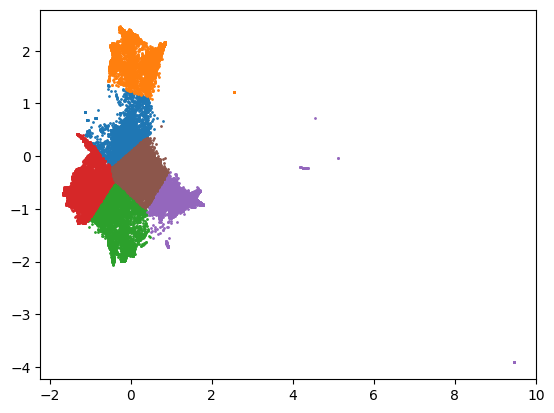

In [16]:
import matplotlib.pyplot as plt


for i in range(0, 6):
  _df = df[df['kmeans_cluster_tsne'] == i]
  plt.scatter(x=_df.kmeans_x, y=_df.kmeans_y, s=1)

In [17]:
df.groupby('kmeans_cluster').count()

,id,title,contents,text,kmeans_cluster_tsne,kmeans_x,kmeans_y
kmeans_cluster,,,,,,,
0,9119,9119,9119,9119,9119,9119,9119
1,8482,8482,8482,8482,8482,8482,8482
2,11692,11692,11692,11692,11692,11692,11692
3,10054,10054,10054,10054,10054,10054,10054
4,11217,11217,11217,11217,11217,11217,11217
5,9436,9436,9436,9436,9436,9436,9436


In [18]:
mapping_dict = {
    0: 4,
    1: 2,
    2: 0,
    3: 5,
    4: 1,
    5: 3
}
df['mapping2'] = df['kmeans_cluster'].apply(lambda x: mapping_dict[x])

In [19]:
sample = pd.read_csv('./sample_submission.csv')

sample['category'] = df['mapping2'].values
sample['category'].head()

0    0
1    3
2    2
3    4
4    4
Name: category, dtype: int64

In [20]:
sample.to_csv('v2_tsne2.csv', index=False)

# Fine-tuning

### centroid 구하기

In [22]:
kmeans.cluster_centers_

array([[ 0.01464317,  0.00501535, -0.00506705, ..., -0.01053788,
        -0.00890202, -0.0182925 ],
       [ 0.01514248,  0.03203293, -0.0026227 , ...,  0.00963168,
        -0.000571  , -0.01448125],
       [-0.02073061,  0.01167797,  0.00253182, ...,  0.0064171 ,
        -0.00149393, -0.01455426],
       [-0.00559506,  0.06729662,  0.0054383 , ..., -0.00193413,
        -0.00418538, -0.00975494],
       [-0.01467237,  0.02674009, -0.00164609, ..., -0.01219276,
        -0.00748211, -0.01318814],
       [ 0.01527011,  0.00999526,  0.00729487, ...,  0.00919716,
        -0.00997477,  0.00674967]], dtype=float32)

In [23]:
df[df['kmeans_cluster'] == 0]['text'].head(3)

3    macromedia contributes ebay stores : macromedia announced special version contribute website editing application designed simplify creation customisation ebay stores .
4                                                                            qualcomm plans phone cellular repairs : over-the-air fixes cell phones comes qualcomm 's cdma .
5                                                                        thomson back both blu-ray hd-dvd : company , one core backers blu-ray , also support rival format .
Name: text, dtype: object

In [24]:
print(df['text'][df[df['kmeans_cluster'] == 0]['text'].head(3).index[0]])
print(df['text'][df[df['kmeans_cluster'] == 0]['text'].head(3).index[1]])
print(df['text'][df[df['kmeans_cluster'] == 0]['text'].head(3).index[2]])

macromedia contributes ebay stores : macromedia announced special version contribute website editing application designed simplify creation customisation ebay stores .
qualcomm plans phone cellular repairs : over-the-air fixes cell phones comes qualcomm 's cdma .
thomson back both blu-ray hd-dvd : company , one core backers blu-ray , also support rival format .


In [25]:
df[df['kmeans_cluster'] == 1]['text'].head(3)

2     only lovers left alive 's tilda swinton talks about almost quitting acting yasmine hamdan performs 'hal ' live in nyc ( huffpo exclusive videos ) authors : yasmine hamdan performs 'hal ' also sings film scene two world-weary vampires begin heal find way continue living remember power mystery creation .
10                                                                                                                                                                        harry ; argy-bargy : prince charles asked scotland yard in-depth report son harry ; trip argentina reports excessive drinking kidnap plot .
25                                                                                                                                                                                                                                                                                      be top : // short_description
Name: text, dtype: object

In [26]:
print(df['text'][df[df['kmeans_cluster'] == 1]['text'].head(3).index[0]])
print(df['text'][df[df['kmeans_cluster'] == 1]['text'].head(3).index[1]])
print(df['text'][df[df['kmeans_cluster'] == 1]['text'].head(3).index[2]])

only lovers left alive 's tilda swinton talks about almost quitting acting yasmine hamdan performs 'hal ' live in nyc ( huffpo exclusive videos ) authors : yasmine hamdan performs 'hal ' also sings film scene two world-weary vampires begin heal find way continue living remember power mystery creation .
harry ; argy-bargy : prince charles asked scotland yard in-depth report son harry ; trip argentina reports excessive drinking kidnap plot .
be top : // short_description


In [27]:
df[df['kmeans_cluster'] == 2]['text'].head(3)

0     spanish coach facing action race row : madrid ( afp ) - spanish national team coach luis aragones faces formal investigation spain ; football federation decided open disciplinary proceedings racist comments thierry henry france arsenal .
6                                                                                                                                    time talk baseball : it 's time talk serious risks potential benefits building expensive ballpark washington .
13                                                                        game day preview game time : : pm : charlotte , north carolina ( ticker ) -- the detroit shock face critical road test saturday take charlotte sting charlotte coliseum .
Name: text, dtype: object

In [28]:
print(df['text'][df[df['kmeans_cluster'] == 2]['text'].head(3).index[0]])
print(df['text'][df[df['kmeans_cluster'] == 2]['text'].head(3).index[1]])
print(df['text'][df[df['kmeans_cluster'] == 2]['text'].head(3).index[2]])

spanish coach facing action race row : madrid ( afp ) - spanish national team coach luis aragones faces formal investigation spain ; football federation decided open disciplinary proceedings racist comments thierry henry france arsenal .
time talk baseball : it 's time talk serious risks potential benefits building expensive ballpark washington .
game day preview game time : : pm : charlotte , north carolina ( ticker ) -- the detroit shock face critical road test saturday take charlotte sting charlotte coliseum .


In [29]:
df[df['kmeans_cluster'] == 3]['text'].head(3)

8                                                                                                                       obama marks anniversary of / attacks with moment of silence authors : we stand strong ever .
9                                                                                                            republican congressman says trump should apologize to obama and the uk authors : best hold breath one .
11    kerry rolls tax-cut plan middle class : after two weeks focusing iraq , democratic presidential challenger john kerry turned emphasis economy saturday , delivering called plan quot ; middle-class families .
Name: text, dtype: object

In [30]:
print(df['text'][df[df['kmeans_cluster'] == 3]['text'].head(3).index[0]])
print(df['text'][df[df['kmeans_cluster'] == 3]['text'].head(3).index[1]])
print(df['text'][df[df['kmeans_cluster'] == 3]['text'].head(3).index[2]])

obama marks anniversary of / attacks with moment of silence authors : we stand strong ever .
republican congressman says trump should apologize to obama and the uk authors : best hold breath one .
kerry rolls tax-cut plan middle class : after two weeks focusing iraq , democratic presidential challenger john kerry turned emphasis economy saturday , delivering called plan quot ; middle-class families .


In [31]:
df[df['kmeans_cluster'] == 4]['text'].head(3)

7                                                                         bump stock maker resumes sales one month after las vegas mass shooting authors : move along nothing see .
20                                                                        deere 's color is green : with big tractors , big sales , big earnings , deere 's hoeing profitable row .
27    kmart-sears merger price , quality : average customers know thing ministers high finance understand : it ; price . shoppers thursday billings sears store eager find proposed
Name: text, dtype: object

In [32]:
print(df['text'][df[df['kmeans_cluster'] == 4]['text'].head(3).index[0]])
print(df['text'][df[df['kmeans_cluster'] == 4]['text'].head(3).index[1]])
print(df['text'][df[df['kmeans_cluster'] == 4]['text'].head(3).index[2]])

bump stock maker resumes sales one month after las vegas mass shooting authors : move along nothing see .
deere 's color is green : with big tractors , big sales , big earnings , deere 's hoeing profitable row .
kmart-sears merger price , quality : average customers know thing ministers high finance understand : it ; price . shoppers thursday billings sears store eager find proposed


In [33]:
df[df['kmeans_cluster'] == 5]['text'].head(3)

1                                                                                bruce lee statue divided city : in bosnia , one man ; hero often another man ; villain , citizens decided honour one serbs , croats muslims look - kung fu great bruce lee .
29    israel kills palestinians big gaza incursion ( reuters ) : reuters - israeli forces killed three\palestinians , including two teenagers , wednesday after\storming northern gaza strip third time as\many months quell palestinian rocket fire israel .
34                                                    the folly sole superpower writ small authors : think little imperial folly -- 's backstory . in years invading iraq disbanding saddam hussein 's military u.s. sunk $ billion standing new iraqi army .
Name: text, dtype: object

In [34]:
print(df['text'][df[df['kmeans_cluster'] == 5]['text'].head(3).index[0]])
print(df['text'][df[df['kmeans_cluster'] == 5]['text'].head(3).index[1]])
print(df['text'][df[df['kmeans_cluster'] == 5]['text'].head(3).index[2]])

bruce lee statue divided city : in bosnia , one man ; hero often another man ; villain , citizens decided honour one serbs , croats muslims look - kung fu great bruce lee .
israel kills palestinians big gaza incursion ( reuters ) : reuters - israeli forces killed three\palestinians , including two teenagers , wednesday after\storming northern gaza strip third time as\many months quell palestinian rocket fire israel .
the folly sole superpower writ small authors : think little imperial folly -- 's backstory . in years invading iraq disbanding saddam hussein 's military u.s. sunk $ billion standing new iraqi army .


In [35]:
mapping_dict = {
    0: 1,
    1: 3,
    2: 2,
    3: 0,
    4: 4,
    5: 5
}

In [37]:
df['mapping'] = df['kmeans_cluster'].apply(lambda x: mapping_dict[x])

In [38]:
sample = pd.read_csv('sample_submission.csv')

In [39]:
sample['category'] = df['mapping'].values
sample['category'].head()

0    2
1    5
2    3
3    1
4    1
Name: category, dtype: int64

## centroid와 거리가 먼 점 구하기

In [36]:
close_index=[]
for idx, row in df_embeddings.iterrows():
    distances_to_centers = [np.linalg.norm(center - row.values) for center in kmeans.cluster_centers_]

    current_cluster = df['kmeans_cluster'][idx]  # 'clusters'는 군집 라벨들을 저장하는 배열이어야 합니다.

    # 현재 데이터 포인트의 클러스터를 제외한 최소 거리 찾기
    distances_to_centers[current_cluster] = np.inf
    closest_center_distance = np.min(distances_to_centers)

    # 필요에 따라 임계값 설정
    if closest_center_distance < 0.87:
        print(f"Data point {idx} is close to another cluster center.")
        close_index.append(idx)
print(len(close_index))

Data point 747 is close to another cluster center.
Data point 1960 is close to another cluster center.
Data point 1965 is close to another cluster center.
Data point 2008 is close to another cluster center.
Data point 2427 is close to another cluster center.
Data point 2653 is close to another cluster center.
Data point 2731 is close to another cluster center.
Data point 3038 is close to another cluster center.
Data point 3504 is close to another cluster center.
Data point 4390 is close to another cluster center.
Data point 4524 is close to another cluster center.
Data point 5352 is close to another cluster center.
Data point 5436 is close to another cluster center.
Data point 5921 is close to another cluster center.
Data point 6750 is close to another cluster center.
Data point 6908 is close to another cluster center.
Data point 7075 is close to another cluster center.
Data point 7186 is close to another cluster center.
Data point 7193 is close to another cluster center.
Data point 75

In [29]:
pd.set_option('display.max_rows', None)
df.iloc[close_index]['text']

747                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [104]:
df.iloc[close_index]['mapping']

Series([], Name: mapping, dtype: int64)

In [37]:
len(df)

60000

In [46]:
sample['category'].iloc[9065]=2
sample['category'].iloc[27572]=1
sample['category'].iloc[46060]=0
sample['category'].iloc[747]=4
sample['category'].iloc[1237]=2
sample['category'].iloc[3045]=2
sample['category'].iloc[4841]=2
sample['category'].iloc[7862]=1
sample['category'].iloc[8745]=5
sample['category'].iloc[9065]=5
sample['category'].iloc[14043]=1
sample['category'].iloc[14396]=2
sample['category'].iloc[15475]=5
sample['category'].iloc[16163]=1
sample['category'].iloc[18966]=4
sample['category'].iloc[19930]=1
sample['category'].iloc[20072]=1
sample['category'].iloc[21464]=4
sample['category'].iloc[22446]=0
sample['category'].iloc[23566]=0
sample['category'].iloc[23750]=1
sample['category'].iloc[24221]=1
sample['category'].iloc[25203]=0
sample['category'].iloc[25330]=5
sample['category'].iloc[26195]=5
sample['category'].iloc[27080]=1
sample['category'].iloc[27572]=1
sample['category'].iloc[28171]=0

/tmp/ipykernel_1062539/1057723166.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['category'].iloc[9065]=2
/tmp/ipykernel_1062539/1057723166.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['category'].iloc[27572]=1
/tmp/ipykernel_1062539/1057723166.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['category'].iloc[46060]=0
/tmp/ipykernel_1062539/1057723166.py:4: SettingWithCopyWarning: 
A value is trying 

In [105]:
sample['category'].iloc[9065]=2
sample['category'].iloc[27572]=1
sample['category'].iloc[46060]=0

/tmp/ipykernel_1065009/3064169943.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['category'].iloc[9065]=2
/tmp/ipykernel_1065009/3064169943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['category'].iloc[27572]=1
/tmp/ipykernel_1065009/3064169943.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['category'].iloc[46060]=0


In [106]:
print(sample['category'].iloc[9065])
print(sample['category'].iloc[27572])
print(sample['category'].iloc[46060])

2
1
0


In [107]:
sample.to_csv('change6_v2_submit6.csv', index=False)

In [37]:
final = pd.read_csv('/project/datacamp/team16/t16user1/baseline_submit.csv')

In [99]:
final

,id,category
0,NEWS_00000,3
1,NEWS_00001,5
2,NEWS_00002,1
3,NEWS_00003,4
4,NEWS_00004,4
...,...,...
59995,NEWS_59995,3
59996,NEWS_59996,0
59997,NEWS_59997,3
59998,NEWS_59998,0
